### **Bibliotecas**

In [11]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

### **Import Data**

In [12]:
dataset_name = 'diabetes_prediction_dataset.csv'
dataset = pd.read_csv(dataset_name)

dataset.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [13]:
print(f">> Dataset shape: {dataset.shape}")

>> Dataset shape: (100000, 9)


In [14]:
print(f">> Proporção das classes: \n{dataset['diabetes'].value_counts()}" )

>> Proporção das classes: 
diabetes
0    91500
1     8500
Name: count, dtype: int64


#### **Gerar novos datasets**

In [15]:
# Gerar e salvar novo dataset contendo dados negativos
diabetes_negative = dataset.loc[dataset['diabetes'] == 0]

diabetes_negative.to_csv('diabetes_negative.csv', index=False)
diabetes_negative.shape

(91500, 9)

In [16]:
# Gerar e salvar novo dataset contendo dados positivos
diabetes_positive = dataset.loc[dataset['diabetes'] == 1]

diabetes_positive.to_csv('diabetes_positive.csv', index=False)
diabetes_positive.shape

(8500, 9)

### **Normalizar e Encode**

In [17]:
def set(dataset):
    X = dataset.drop(columns=['diabetes'])

    # Codifica as colunas 'gender', 'smoking_history'
    columns_to_encode = ['gender', 'smoking_history']
    X_encoded = pd.get_dummies(X, columns=columns_to_encode)
    X_train, X_test = train_test_split(X_encoded, test_size=0.2, random_state=1234)

    scaler = StandardScaler(with_mean=False)
    scaler.fit(X_train)

    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled

In [18]:
X_train_scaled, X_test_scaled = set(diabetes_negative)

### **GP**

In [19]:
import matplotlib.pyplot as plt
# import seaborn as sns

from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal

In [20]:
df =

SyntaxError: invalid syntax (3599030753.py, line 1)

In [21]:
n_components = 50
gmm = GaussianMixture(n_components=n_components, random_state=42, covariance_type='full')

y_gmm = gmm.fit_predict(X_train_scaled)

In [22]:
# Get the score for each sample
score = gmm.score_samples(X_train_scaled)
# Save score as a column
diabetes_negative['score'] = score
# Get the score threshold for anomaly
pct_threshold = np.percentile(score, 4)
# Print the score threshold
print(f'The threshold of the score is {pct_threshold:.2f}')
# Label the anomalies
diabetes_negative['anomaly_gmm_pct'] = diabetes_negative['score'].apply(lambda x: 1 if x < pct_threshold else 0)

ValueError: Length of values (73200) does not match length of index (91500)

In [ ]:
probs = gmm.predict_proba(X_train_scaled)
anomaly_scores = -np.log(np.max(probs, axis=1))
threshold = 1.0
anomalies = anomaly_scores > threshold

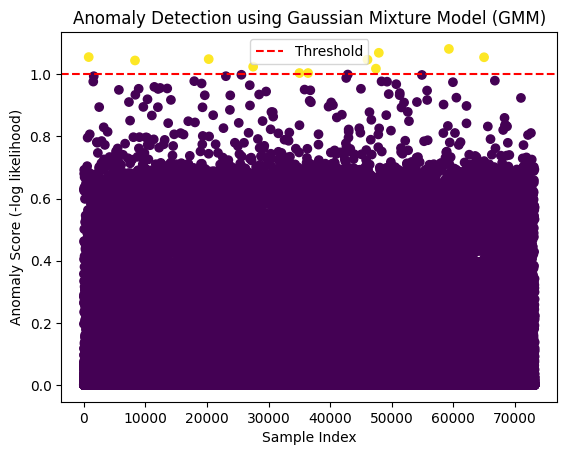

In [ ]:
plt.scatter(range(X_train_scaled.shape[0]), anomaly_scores, c=anomalies, cmap='viridis')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.title('Anomaly Detection using Gaussian Mixture Model (GMM)')
plt.xlabel('Sample Index')
plt.ylabel('Anomaly Score (-log likelihood)')
plt.legend()
plt.show()

In [ ]:
# Imprimir valores anômalos
print("Valores Anômalos:")
print(X_train_scaled[anomalies])

Valores Anômalos:
[[0.85180685 0.         0.         3.80723788 3.60267023 2.92434731
  2.03392637 0.         0.         2.06362169 0.         0.
  0.         0.         0.        ]
 [0.71731103 0.         0.         5.86962273 6.79360672 2.33947785
  2.03392637 0.         0.         2.06362169 0.         0.
  0.         0.         0.        ]
 [0.89663878 0.         0.         3.08100175 6.27893954 2.92434731
  2.03392637 0.         0.         2.06362169 0.         0.
  0.         0.         0.        ]
 [0.62764715 0.         0.         4.0021584  4.63200458 2.92434731
  0.         2.03409385 0.         2.06362169 0.         0.
  0.         0.         0.        ]
 [0.67247909 0.         0.         4.29453918 4.63200458 2.92434731
  2.03392637 0.         0.         2.06362169 0.         0.
  0.         0.         0.        ]
 [0.67247909 0.         0.         4.29453918 4.63200458 2.92434731
  2.03392637 0.         0.         2.06362169 0.         0.
  0.         0.         0.        